# The main pipeline for analyzing the IFG+AIP data recorded from the Bolu Lab

### here we are using

In [1]:
import numpy as np
import mat73
import pandas as pd
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.signal import filtfilt,butter,hilbert,convolve2d,convolve
import scipy.io as sio
from Bolu_IFG.utils import get_train_test,decoding,reformat
from nltk.stem import WordNetLemmatizer
import nltk
import hyperopt
# Download the CMU Pronouncing Dictionary
nltk.download('cmudict')

# Create a sentence to phoneme dictionary
words_to_phonemes = nltk.corpus.cmudict.dict()
# here we assume the source root to be Speech/Bolu_IFG

[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\Owner\AppData\Roaming\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [2]:
date='Jan05_2024' # here we have Jan05_2024, Dec06_2023 data
data_path=f'../Bolu_IFG/processed_data/{date}_all_blocks_new_new.mat'

#data_path= f'Bolu_IFG/raw_data/Dat_{date}.mat'
try:
    raw_data=pd.DataFrame(sio.loadmat(data_path)['all_data'])
except:
    raw_data=pd.DataFrame(mat73.loadmat(data_path)['all_data'])

In [3]:
raw_data

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,[[]],"[[-0.043888327819278476, 0.0681434122188873, -...",[[1.32]],[We stayed up late and ____ the fat. ],[[4.88]],[Chew\r],[[8.796237999999997]],[[9.275473999999999]],[[[chewed]]],[[2000]],[1],[1],[m]
1,[[]],"[[-0.09207314303759025, -0.05499816393990243, ...",[[1.5]],"[When I gain weight, I ___ new holes in my bel...",[[5.48]],[Punch\r],[[8.840466000000001]],[[9.461115999999999]],[[[punch]]],[[2000]],[2],[2],[h]
2,[[]],"[[-0.03611789634100509, -0.0675115884276561, -...",[[1.52]],[The baby is hungry and ___ for food. ],[[5.3]],[Cry\r],[[9.188171000000002]],[[9.734186000000001]],[[[cried]]],[[2000]],[3],[1],[m]
3,[[]],"[[-0.07127626799081038, -0.07013537529332678, ...",[[1.52]],"[Every year, she ____ to remember his birthday. ]",[[5.14]],[Fail\r],[[10.395449000000001]],[[11.020027000000002]],[[[fails]]],[[2000]],[3],[3],[a]
4,[[]],"[[0.1672028321920283, 0.011043970237542503, -0...",[[1.52]],[The children ____ and bounce on the trampolin...,[[5.04]],[Jump\r],[[9.790788000000001]],[[10.246454999999996]],[[[jump]]],[[2000]],[2],[2],[l]
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,[[]],"[[-0.11041862247867625, -0.17687359510257122, ...",[[1.5]],[She hid behind the curtains and ____ through. ],[[5.48]],[Peek\r],[[8.904220999999989]],[[9.347943999999988]],[[[peeked]]],[[2000]],[1],[1],[e]
125,[[]],"[[-0.07346447450077521, -0.07927457877142478, ...",[[1.5]],[She never ____exams because she studies hard. ],[[5.16]],[Fail\r],[[8.755396999999995]],[[9.16665299999999]],[[[failed]]],[[2000]],[3],[3],[a]
126,[[]],"[[0.023524994882256817, 0.009959175362256961, ...",[[1.5]],"[Since his ankle hurts, he ___ on one leg. ]",[[5.22]],[Hop\r],[[8.87081599999999]],[[9.390297000000018]],[[[hopped]]],[[2000]],[3],[3],[l]
127,[[]],"[[0.009246375021900186, 0.024604390014955395, ...",[[1.52]],"[When I bake, I always ___ the counter afterwa...",[[5.04]],[Wipe\r],[[9.371603]],[[9.77203599999996]],[[[wipe]]],[[2000]],[2],[2],[h]


In [4]:
# labels
correct_label=raw_data[10].to_numpy()
answered_label=raw_data[11].to_numpy()
answered_words=raw_data[8].to_numpy()
answered_semantic_label=raw_data[12].to_numpy()
correct_label=np.array([a[0] for a in correct_label])
answered_label=np.array([a[0] for a in answered_label])
answered_semantic_label=np.array([a[0] for a in answered_semantic_label])
lemmatizer = WordNetLemmatizer()
answered_lexical_item=np.array([lemmatizer.lemmatize(a[0][0][0],pos='v') for a in answered_words])
first_phonemes=np.array([words_to_phonemes[a][0][0] for a in answered_lexical_item])
# time stamps
phrase_on=raw_data[2].to_numpy()
word_on=raw_data[4].to_numpy()
voice_on=raw_data[6].to_numpy()
voice_off=raw_data[7].to_numpy()

phrase_on=np.array([a[0][0] for a in phrase_on])
word_on=np.array([a[0][0] for a in word_on])
voice_on=np.array([a[0][0] for a in voice_on])
voice_off=np.array([a[0][0] for a in voice_off])

fs=raw_data[9][0][0][0]

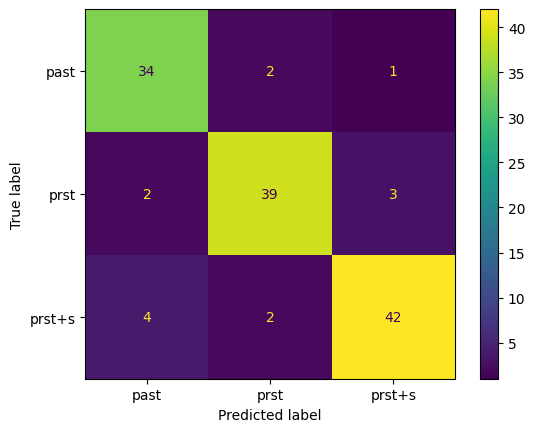

In [5]:
cm=confusion_matrix(correct_label,answered_label)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['past','prst','prst+s'])
disp.plot()
plt.show()

In [6]:
# concatenate the pre-cue data and the actual signal
# pre_cue=raw_data[0].to_list()
# post_cue=raw_data[1].to_list()
# all_data=[np.concatenate([pre_cue[i],post_cue[i]],axis=1) for i in range(len(pre_cue))]
all_data=raw_data[1].to_list()

## preprocessing
### what have already been done
- resampled data to 2000 Hz
- low passed to 0-500Hz (HGB) / band passed from 300Hz to 5kHz (Spike band)
- Common-Average-Reference by array
- computed the envelope (Spike band)
- Z-scored by channel (Spike band)
### what needs to be done
- For extracting HGB power
-- Band pass the data
-- Compute power
-- Smooth the data using non-causal filter (exponential decay)
-- Z-score by trial using pre-cue epoch as baseline
-- Artifact rejection
- For extract spike band power
-- Nothing


In [7]:
# band pass + HGB power + smoothing + zscored
def exponential_decay(decay=0.05,N=200):
    '''
    :param decay: decay coefficient
    :param N: point (length) of the filter
    :return: a time domain filter
    '''
    x=np.arange(N)
    return np.exp(-decay * x)
kernel=exponential_decay()
kernel=kernel

def convolution(trial_data):
    return convolve(trial_data, kernel, mode='valid')

################## for HGB power processing #############################

# b, a = butter(3, [70,300],btype='band',fs=fs)
# filtered_data=[filtfilt(b,a,trial) for trial in all_data]
# filtered_power_data=[np.abs(hilbert(trial)) for trial in filtered_data]
# smoothed_data=[np.flip(np.apply_along_axis(convolution,arr=np.flip(trial,axis=1),axis=1),axis=1) for trial in filtered_power_data]

################# for spike band power processing #######################
#smoothed_data=[np.flip(np.apply_along_axis(convolution,arr=np.flip(trial,axis=1),axis=1),axis=1) for trial in all_data]
smoothed_data=all_data

In [149]:
# time_to_plot=2000
# fig,ax=plt.subplots(4,1,figsize=(6,11))
# x=np.linspace(0,time_to_plot/fs,time_to_plot)
# ax[0].plot(x,all_data[0][0][:time_to_plot])# plot the first second of data
# ax[1].plot(x,filtered_data[0][0][:time_to_plot])
# ax[2].plot(x,filtered_power_data[0][0][:time_to_plot])
# ax[3].plot(x,smoothed_data[0][0][:time_to_plot])
# ax[0].set_ylabel("raw signal")
# ax[1].set_ylabel("band passed signal (70-300 Hz)")
# ax[2].set_ylabel("high gamma power")
# ax[3].set_ylabel("smoother data (causal)")
# ax[3].set_xlabel("time (s)")
# plt.show()

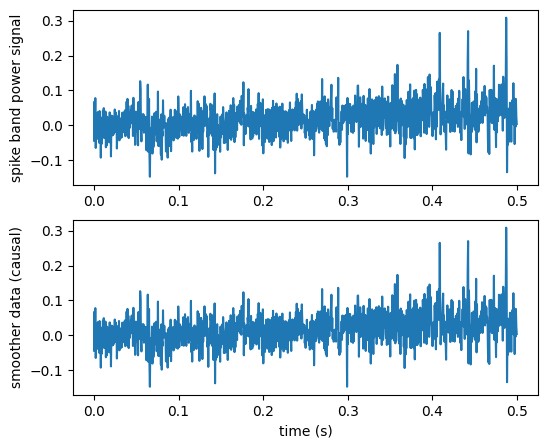

In [150]:
time_to_plot=1000
fig,ax=plt.subplots(2,1,figsize=(6,5))
x=np.linspace(0,time_to_plot/fs,time_to_plot)
ax[0].plot(x,all_data[0][0][:time_to_plot])# plot the first second of data
ax[1].plot(x,smoothed_data[0][0][:time_to_plot])
ax[0].set_ylabel("spike band power signal")
ax[1].set_ylabel("smoother data (causal)")
ax[1].set_xlabel("time (s)")
plt.show()

In [151]:
# zscore each trial using the pre-cue data. zscore by electrode. So that the mean and std of each electrode will be the same...
def zscore(data,mean_val,std_val):
    return (data-mean_val[:,None])/std_val[:,None]
# 
# zscored_data=[zscore(trial,trial[:,:2000].mean(axis=1),trial[:,:2000].std(axis=1)) for trial in smoothed_data]
zscored_data=[zscore(trial,trial.mean(axis=1),trial.std(axis=1)) for trial in smoothed_data]

In [152]:
#  format the data to the same length
length=[trial.shape[1] for trial in zscored_data]
min_length=min(length)
processed_data=np.stack([trial[:,:min_length] for trial in zscored_data]) # n_trials x n_channels x n_time_points

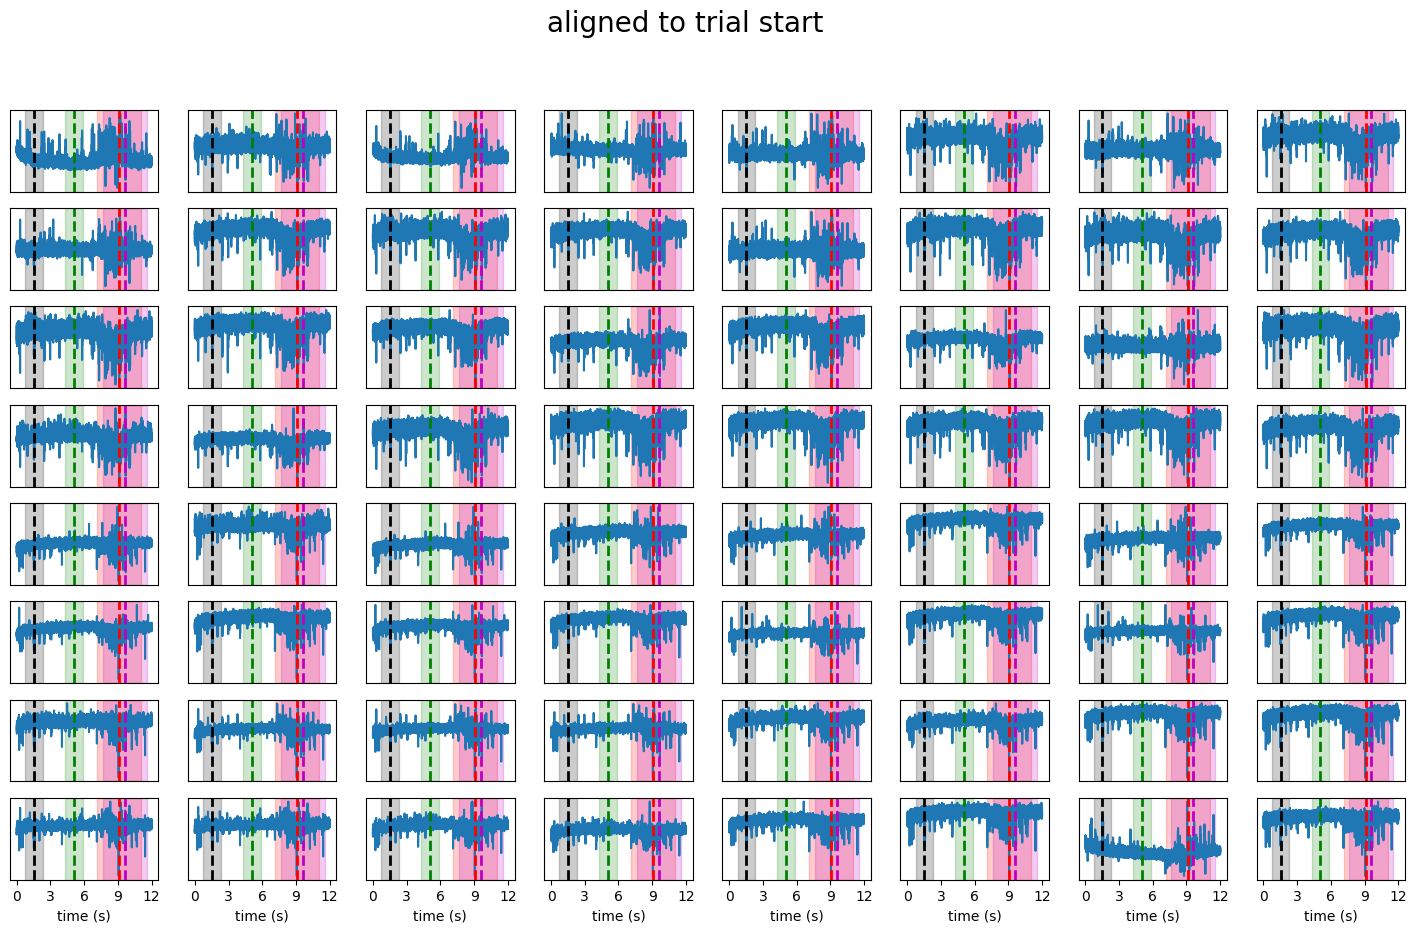

In [153]:
# plotting trial-averaged data aligning to the start of the trial
trial_averaged_data=processed_data.mean(axis=0) # getting rid of the baseline period

ave_phrase_on=phrase_on.mean()
std_phrase_on=phrase_on.std()

ave_word_on=word_on.mean()
std_word_on=word_on.std()

ave_voice_on=voice_on.mean()
std_voice_on=voice_on.std()

ave_voice_off=voice_off.mean()
std_voice_off=voice_off.std()

fig,ax=plt.subplots(8,8,figsize=(18,10))
for i in range(trial_averaged_data.shape[0]):
    ax[i//8,i%8].plot(np.linspace(0,trial_averaged_data.shape[-1],trial_averaged_data.shape[-1]),trial_averaged_data[i])
    ax[i//8,i%8].set_yticks([])
    if i//8!=7:   
        ax[i//8,i%8].set_xticks([])
    else:
        ax[i//8,i%8].set_xticks(np.linspace(0,trial_averaged_data.shape[-1],5), np.int16(np.linspace(0,trial_averaged_data.shape[-1]/fs,5)))
        ax[i//8,i%8].set_xlabel("time (s)")
    
    ax[i//8,i%8].axvspan((ave_phrase_on)*fs-std_phrase_on*fs,(ave_phrase_on)*fs+std_phrase_on*fs,color='k',alpha=0.2)
    ax[i//8,i%8].axvspan((ave_word_on)*fs-std_word_on*fs,(ave_word_on)*fs+std_word_on*fs,color='g',alpha=0.2)
    ax[i//8,i%8].axvspan((ave_voice_on)*fs-std_voice_on*fs,(ave_voice_on)*fs+std_voice_on*fs,color='r',alpha=0.2)
    ax[i//8,i%8].axvspan((ave_voice_off)*fs-std_voice_off*fs,(ave_voice_off)*fs+std_voice_off*fs,color='m',alpha=0.2)
    
    ax[i//8,i%8].axvline((ave_phrase_on)*fs,color='k',linestyle='--',linewidth=2)
    ax[i//8,i%8].axvline((ave_word_on)*fs,color='g',linestyle='--',linewidth=2)
    ax[i//8,i%8].axvline((ave_voice_on)*fs,color='r',linestyle='--',linewidth=2)
    ax[i//8,i%8].axvline((ave_voice_off)*fs,color='m',linestyle='--',linewidth=2)
    
plt.suptitle("aligned to trial start",fontsize=20)
plt.show()

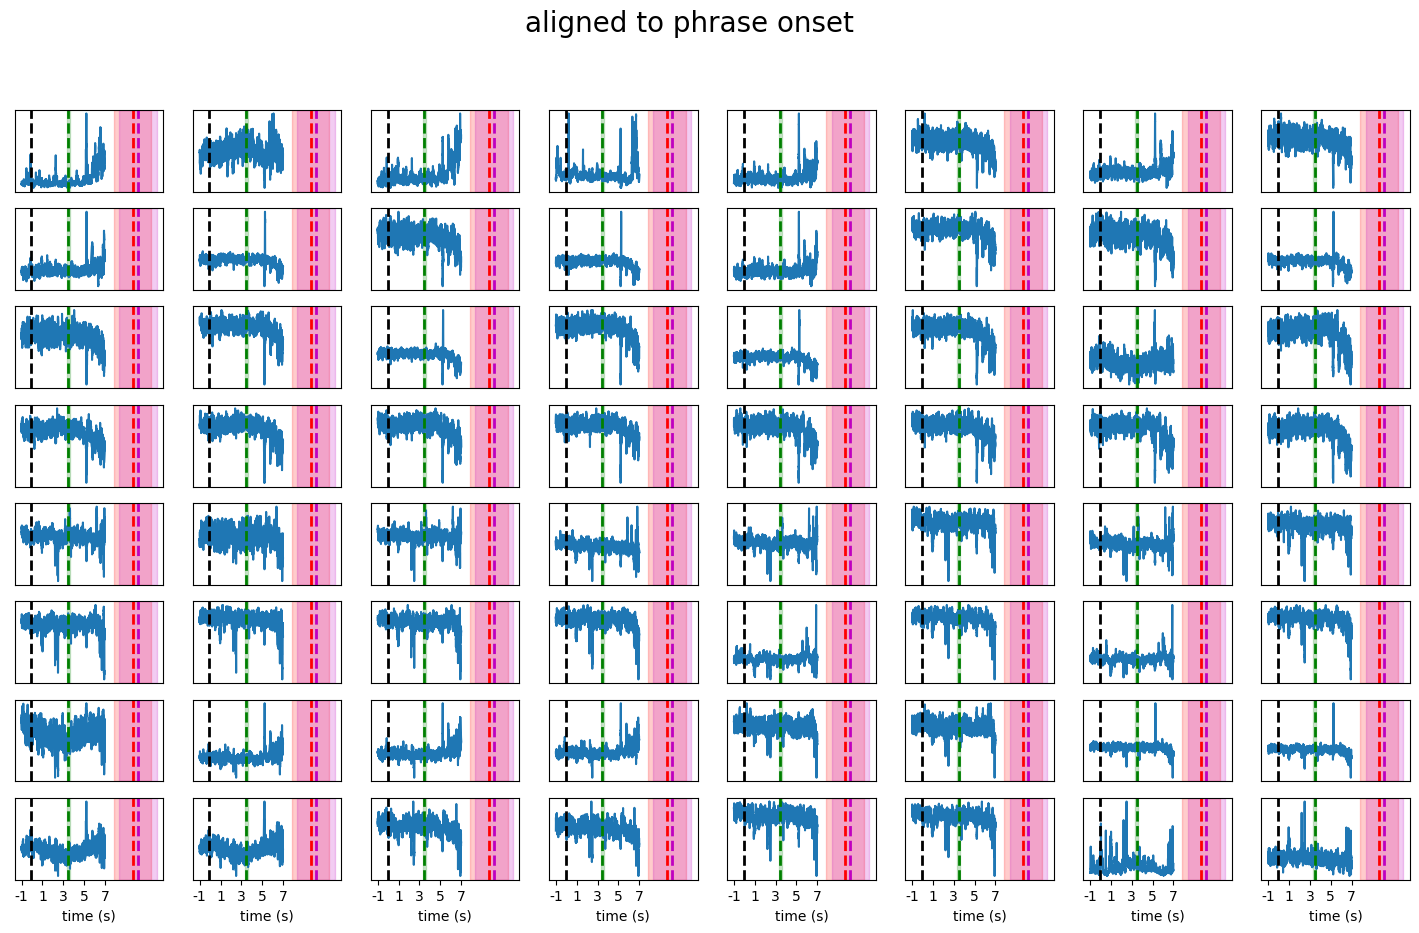

In [53]:
# plotting trial-averaged data in aligning to the phrase onset. 1s before and 8s after
processed_data_phrase_on=np.stack([trial[:,int(phrase_on[i]*fs-1*fs) : int(phrase_on[i]*fs+7.5*fs)] for i,trial in enumerate(zscored_data)])
trial_averaged_data_phrase_on=processed_data_phrase_on.mean(axis=0) # getting rid of the baseline period

ave_phrase_on=1

ave_word_on=-(phrase_on-word_on).mean()+ave_phrase_on
std_word_on=(phrase_on-word_on).std()

ave_voice_on=-(phrase_on-voice_on).mean()+ave_phrase_on
std_voice_on=(phrase_on-voice_on).std()

ave_voice_off=-(phrase_on-voice_off).mean()+ave_phrase_on
std_voice_off=(phrase_on-voice_off).std()

fig,ax=plt.subplots(8,8,figsize=(18,10))
for i in range(trial_averaged_data.shape[0]):
    ax[i//8,i%8].plot(trial_averaged_data_phrase_on[i])
    ax[i//8,i%8].set_yticks([])
    if i//8!=7:   
        ax[i//8,i%8].set_xticks([])
    else:
        ax[i//8,i%8].set_xticks(np.linspace(0,8.5*fs,5), np.int16(np.linspace(-1,7.5,5)))
        ax[i//8,i%8].set_xlabel("time (s)")
    
    #ax[i//8,i%8].axvspan((ave_phrase_on-1)*fs-std_phrase_on*fs,(ave_phrase_on-1)*fs+std_phrase_on*fs,color='k',alpha=0.2)
    ax[i//8,i%8].axvspan(ave_word_on * fs - std_word_on * fs, ave_word_on * fs + std_word_on * fs, color='g', alpha=0.2)
    ax[i//8,i%8].axvspan(ave_voice_on * fs - std_voice_on * fs, ave_voice_on * fs + std_voice_on * fs, color='r', alpha=0.2)
    ax[i//8,i%8].axvspan(ave_voice_off * fs - std_voice_off * fs, ave_voice_off * fs + std_voice_off * fs, color='m', alpha=0.2)
    
    ax[i//8,i%8].axvline(ave_phrase_on * fs, color='k', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_word_on * fs, color='g', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_on * fs, color='r', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_off * fs, color='m', linestyle='--', linewidth=2)
plt.suptitle("aligned to phrase onset",fontsize=20)
plt.show()

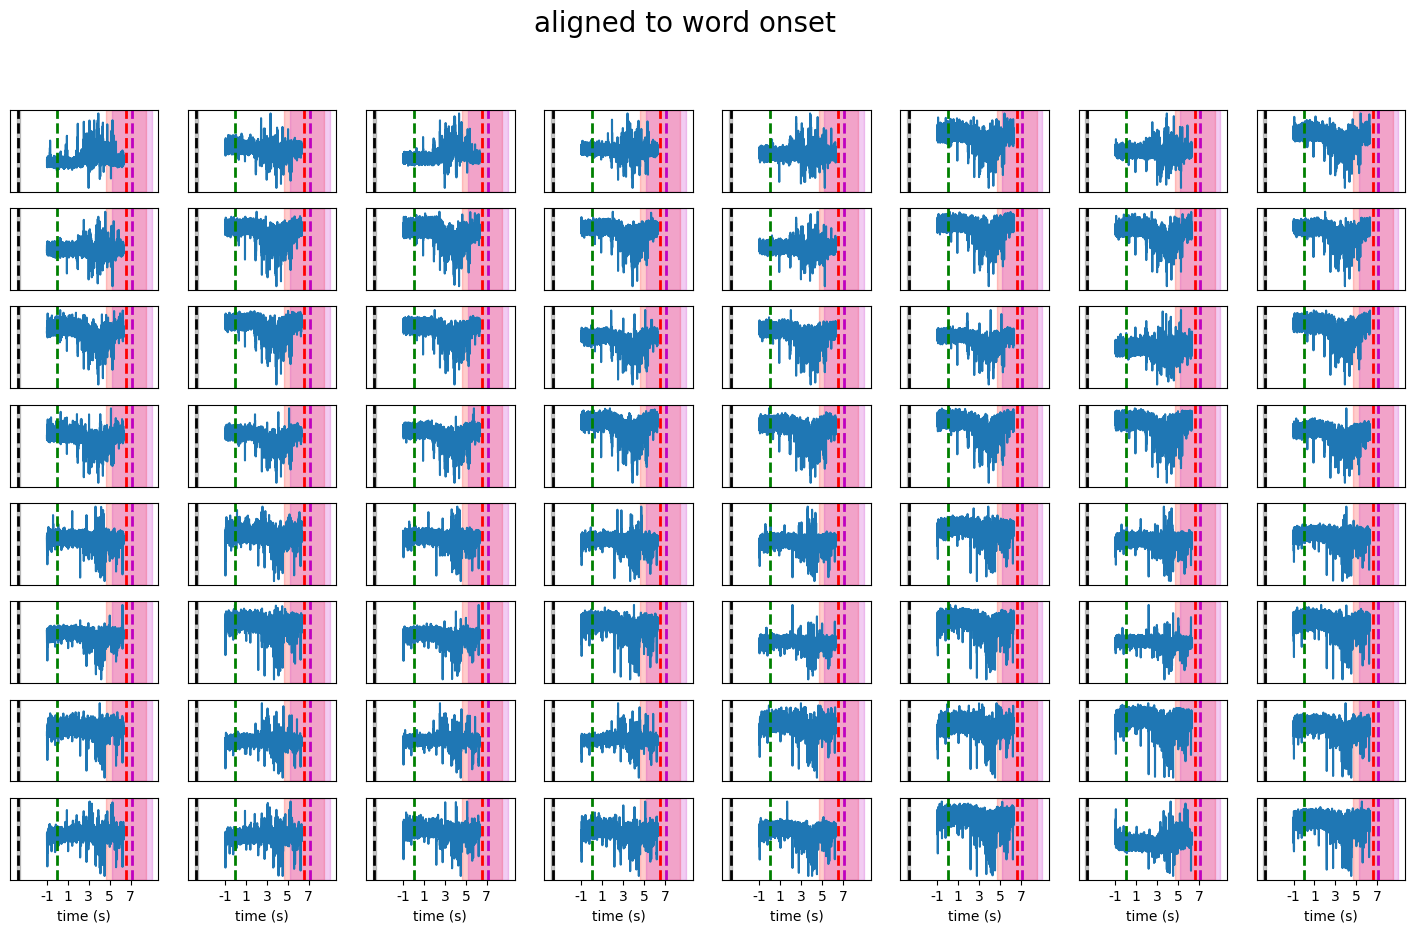

In [34]:
# plotting trial-averaged data in aligning to the word onset. 1s before and 8s after
processed_data_phrase_on=[trial[:,int(word_on[i]*fs-1*fs) : int(word_on[i]*fs+7*fs)] for i,trial in enumerate(zscored_data)]
length=[trial.shape[1] for trial in processed_data_phrase_on]
min_length=min(length)
processed_data_phrase_on=np.stack([trial[:,:min_length] for trial in processed_data_phrase_on]) # n_trials x n_channels x n_time_points
trial_averaged_data_phrase_on=processed_data_phrase_on.mean(axis=0) # getting rid of the baseline period

ave_word_on=1

ave_phrase_on=-(word_on-phrase_on).mean()+ave_word_on
std_phrase_on=(word_on-phrase_on).std()

ave_voice_on=(voice_on-word_on).mean()+ave_word_on
std_voice_on=(voice_on-word_on).std()

ave_voice_off=(voice_off-word_on).mean()+ave_word_on
std_voice_off=(voice_off-word_on).std()

fig,ax=plt.subplots(8,8,figsize=(18,10))
for i in range(trial_averaged_data.shape[0]):
    ax[i//8,i%8].plot(trial_averaged_data_phrase_on[i])
    ax[i//8,i%8].set_yticks([])
    if i//8!=7:   
        ax[i//8,i%8].set_xticks([])
    else:
        ax[i//8,i%8].set_xticks(np.linspace(0,8*fs,5), np.int16(np.linspace(-1,7,5)))
        ax[i//8,i%8].set_xlabel("time (s)")
    
    ax[i//8,i%8].axvspan(ave_phrase_on*fs-std_phrase_on*fs,ave_phrase_on*fs+std_phrase_on*fs,color='k',alpha=0.2)
    #ax[i//8,i%8].axvspan(ave_word_on * fs - std_word_on * fs, ave_word_on * fs + std_word_on * fs, color='g', alpha=0.2)
    ax[i//8,i%8].axvspan(ave_voice_on * fs - std_voice_on * fs, ave_voice_on * fs + std_voice_on * fs, color='r', alpha=0.2)
    ax[i//8,i%8].axvspan(ave_voice_off * fs - std_voice_off * fs, ave_voice_off * fs + std_voice_off * fs, color='m', alpha=0.2)
    
    ax[i//8,i%8].axvline(ave_phrase_on * fs, color='k', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_word_on * fs, color='g', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_on * fs, color='r', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_off * fs, color='m', linestyle='--', linewidth=2)
plt.suptitle("aligned to word onset",fontsize=20)
plt.show()

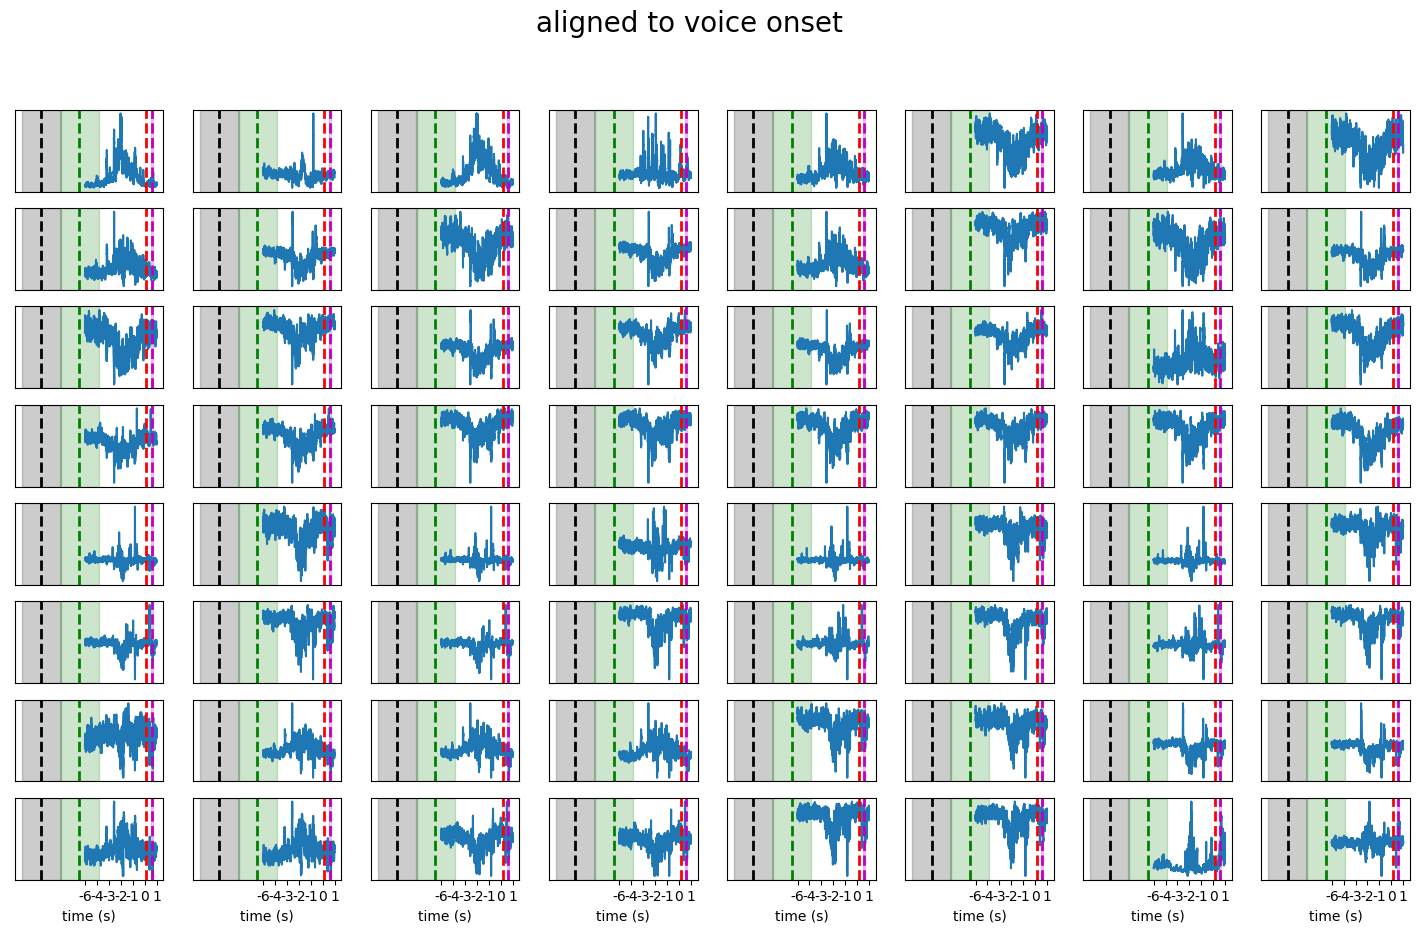

In [55]:
# plotting trial-averaged data in aligning to the phrase onset. 1s before and 8s after
processed_data_voice_on=[trial[:,int(voice_on[i]*fs-6*fs) : int(voice_on[i]*fs+1*fs)] for i,trial in enumerate(zscored_data)]
length=[trial.shape[1] for trial in processed_data_voice_on]
min_length=min(length)
processed_data_voice_on=np.stack([trial[:,:min_length] for trial in processed_data_voice_on]) # n_trials x n_channels x n_time_points
trial_averaged_data_voice_on=processed_data_voice_on.mean(axis=0) # getting rid of the baseline period

ave_voice_on=6

ave_phrase_on=-(voice_on-phrase_on).mean()+ave_voice_on
std_phrase_on=(voice_on-phrase_on).std()

ave_word_on=-(voice_on-word_on).mean()+ave_voice_on
std_word_on=(voice_on-word_on).std()

ave_voice_off=-(voice_on-voice_off).mean()+ave_voice_on
std_voice_off=(voice_off-voice_on).std()

fig,ax=plt.subplots(8,8,figsize=(18,10))
for i in range(trial_averaged_data.shape[0]):
    ax[i//8,i%8].plot(trial_averaged_data_voice_on[i])
    ax[i//8,i%8].set_yticks([])
    if i//8!=7:   
        ax[i//8,i%8].set_xticks([])
    else:
        ax[i//8,i%8].set_xticks(np.linspace(0,7*fs,7), np.int16(np.linspace(-6,1,7)))
        ax[i//8,i%8].set_xlabel("time (s)")
    
    ax[i//8,i%8].axvspan(ave_phrase_on*fs-std_phrase_on*fs,ave_phrase_on*fs+std_phrase_on*fs,color='k',alpha=0.2)
    ax[i//8,i%8].axvspan(ave_word_on * fs - std_word_on * fs, ave_word_on * fs + std_word_on * fs, color='g', alpha=0.2)
    #ax[i//8,i%8].axvspan(ave_voice_on * fs - std_voice_on * fs, ave_voice_on * fs + std_voice_on * fs, color='r', alpha=0.2)
    ax[i//8,i%8].axvspan(ave_voice_off * fs - std_voice_off * fs, ave_voice_off * fs + std_voice_off * fs, color='m', alpha=0.2)
    
    ax[i//8,i%8].axvline(ave_phrase_on * fs, color='k', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_word_on * fs, color='g', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_on * fs, color='r', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_off * fs, color='m', linestyle='--', linewidth=2)
plt.suptitle("aligned to voice onset",fontsize=20)
plt.show()

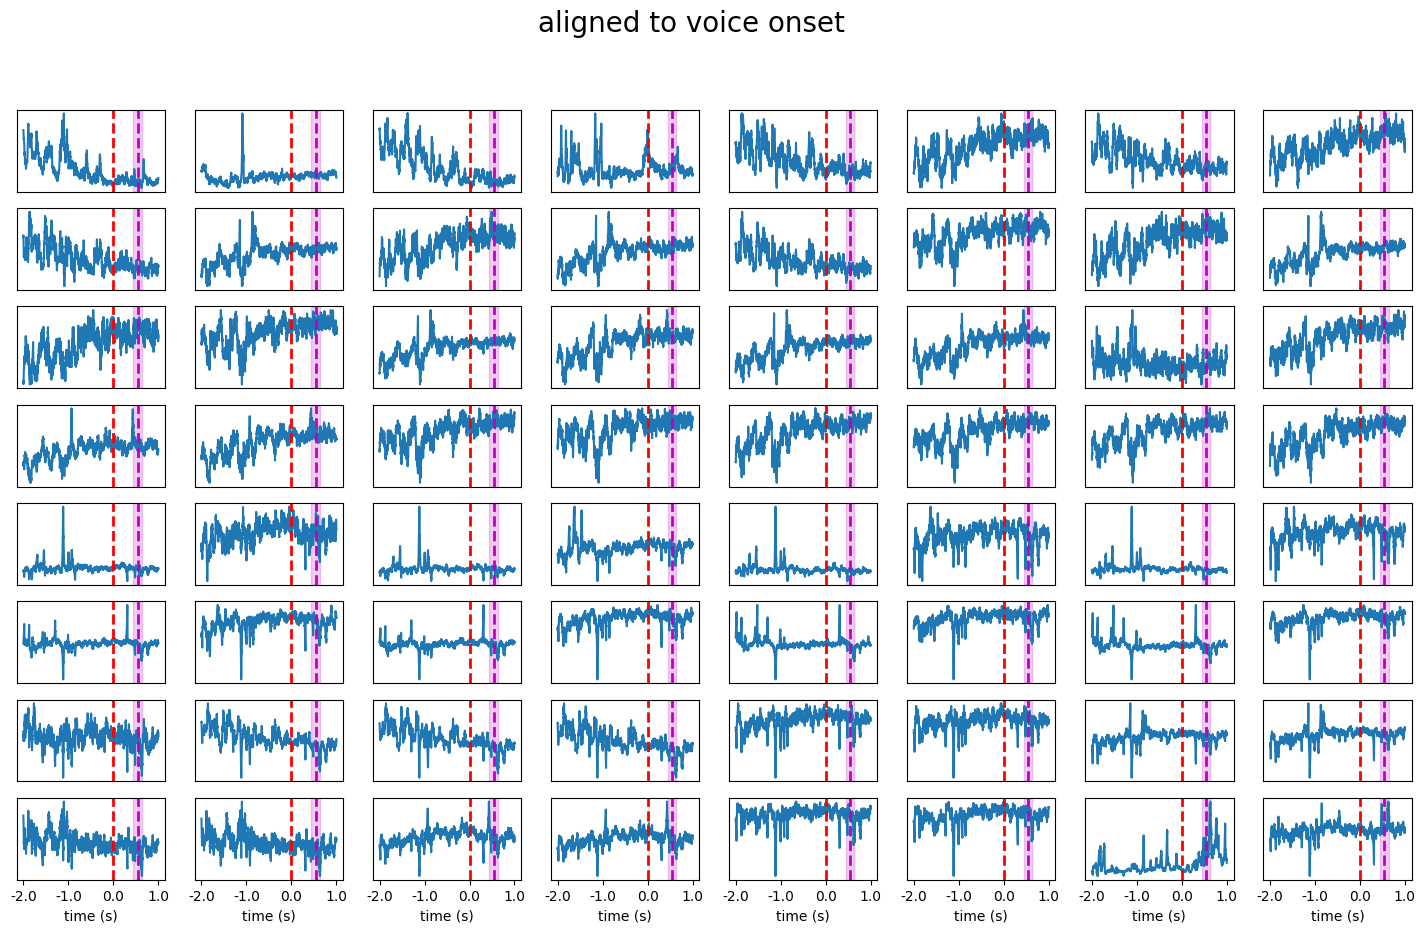

In [56]:
# plotting trial-averaged data in aligning to the phrase onset. 1s before and 8s after
processed_data_voice_on=[trial[:,int(voice_on[i]*fs-2*fs) : int(voice_on[i]*fs+1*fs)] for i,trial in enumerate(zscored_data)]
length=[trial.shape[1] for trial in processed_data_voice_on]
min_length=min(length)
processed_data_voice_on=np.stack([trial[:,:min_length] for trial in processed_data_voice_on]) # n_trials x n_channels x n_time_points
trial_averaged_data_voice_on=processed_data_voice_on.mean(axis=0) # getting rid of the baseline period

ave_voice_on=2

ave_phrase_on=-(voice_on-phrase_on).mean()+ave_voice_on
std_phrase_on=(voice_on-phrase_on).std()

ave_word_on=-(voice_on-word_on).mean()+ave_voice_on
std_word_on=(voice_on-word_on).std()

ave_voice_off=-(voice_on-voice_off).mean()+ave_voice_on
std_voice_off=(voice_off-voice_on).std()

fig,ax=plt.subplots(8,8,figsize=(18,10))
for i in range(trial_averaged_data.shape[0]):
    ax[i//8,i%8].plot(trial_averaged_data_voice_on[i])
    ax[i//8,i%8].set_yticks([])
    if i//8!=7:   
        ax[i//8,i%8].set_xticks([])
    else:
        ax[i//8,i%8].set_xticks(np.linspace(0,3*fs,4), [f"{i:0.1f}" for i in np.linspace(-2,1,4)])
        ax[i//8,i%8].set_xlabel("time (s)")
    
    #ax[i//8,i%8].axvspan(ave_phrase_on*fs-std_phrase_on*fs,ave_phrase_on*fs+std_phrase_on*fs,color='k',alpha=0.2)
    #ax[i//8,i%8].axvspan(ave_word_on * fs - std_word_on * fs, ave_word_on * fs + std_word_on * fs, color='g', alpha=0.2)
    #ax[i//8,i%8].axvspan(ave_voice_on * fs - std_voice_on * fs, ave_voice_on * fs + std_voice_on * fs, color='r', alpha=0.2)
    ax[i//8,i%8].axvspan(ave_voice_off * fs - std_voice_off * fs, ave_voice_off * fs + std_voice_off * fs, color='m', alpha=0.2)
    
    #ax[i//8,i%8].axvline(ave_phrase_on * fs, color='k', linestyle='--', linewidth=2)
    #ax[i//8,i%8].axvline(ave_word_on * fs, color='g', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_on * fs, color='r', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_off * fs, color='m', linestyle='--', linewidth=2)
plt.suptitle("aligned to voice onset",fontsize=20)
plt.show()

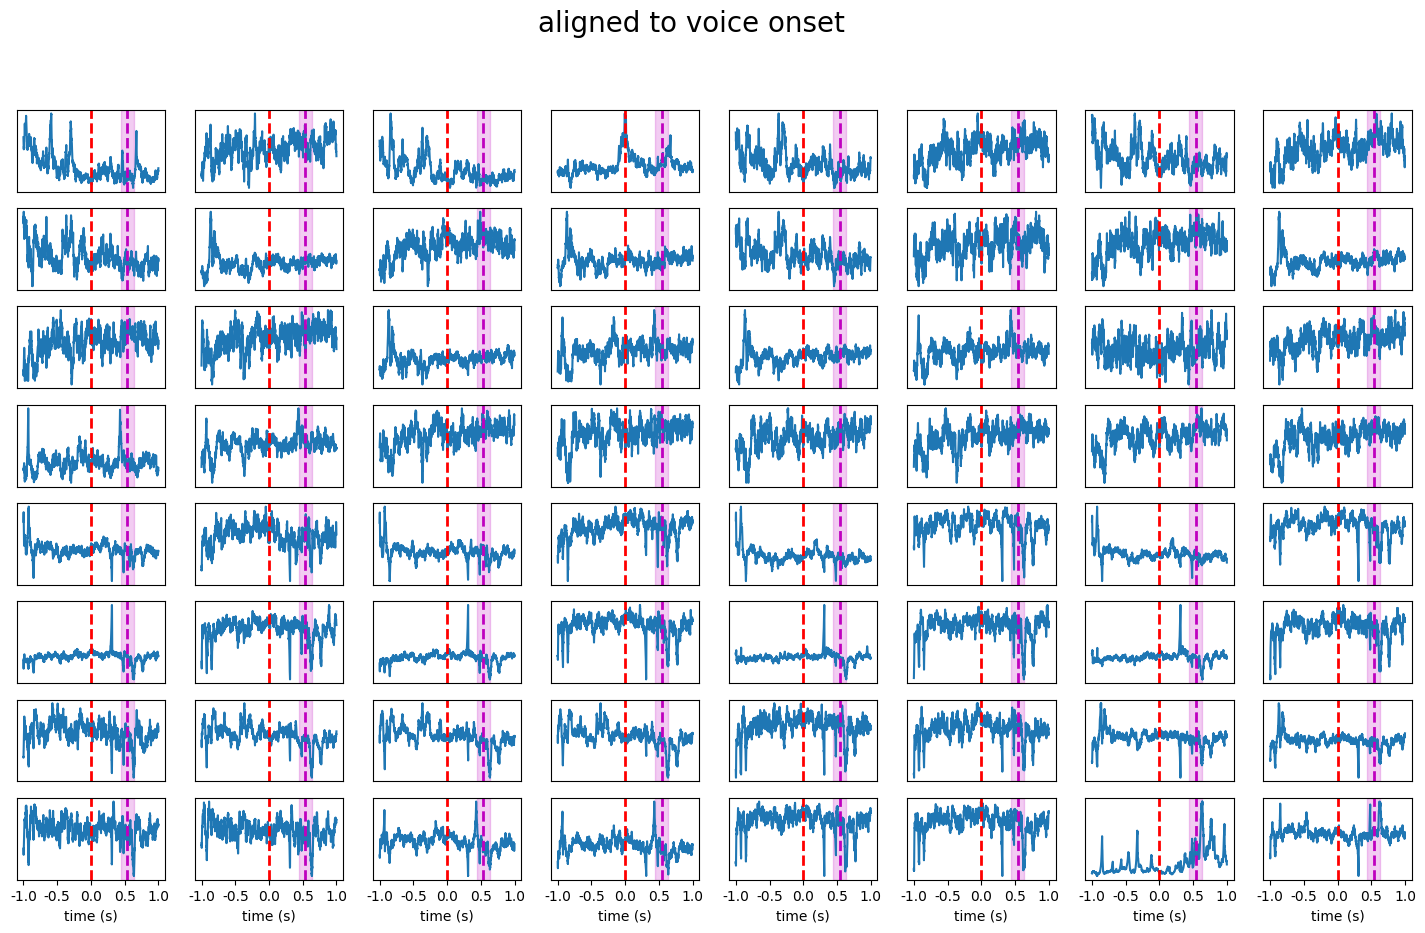

In [57]:
# plotting trial-averaged data in aligning to the phrase onset. 1s before and 8s after
processed_data_voice_on=[trial[:,int(voice_on[i]*fs-1*fs) : int(voice_on[i]*fs+1*fs)] for i,trial in enumerate(zscored_data)]
length=[trial.shape[1] for trial in processed_data_voice_on]
min_length=min(length)
processed_data_voice_on=np.stack([trial[:,:min_length] for trial in processed_data_voice_on]) # n_trials x n_channels x n_time_points
trial_averaged_data_voice_on=processed_data_voice_on.mean(axis=0) # getting rid of the baseline period
#trial_averaged_data_voice_on_max=np.max(np.max(processed_data_voice_on,axis=-1),axis=0)
#trial_averaged_data_voice_on_min=np.min(np.min(processed_data_voice_on,axis=-1),axis=0)
trial_averaged_data_voice_on_max=np.max(trial_averaged_data_voice_on,axis=-1)+0.5
trial_averaged_data_voice_on_min=np.min(trial_averaged_data_voice_on,axis=-1)-0.5

ave_voice_on=1

ave_phrase_on=-(voice_on-phrase_on).mean()+ave_voice_on
std_phrase_on=(voice_on-phrase_on).std()

ave_word_on=-(voice_on-word_on).mean()+ave_voice_on
std_word_on=(voice_on-word_on).std()

ave_voice_off=-(voice_on-voice_off).mean()+ave_voice_on
std_voice_off=(voice_off-voice_on).std()

fig,ax=plt.subplots(8,8,figsize=(18,10))
for i in range(trial_averaged_data.shape[0]):
    ax[i//8,i%8].plot(trial_averaged_data_voice_on[i])
    ax[i//8,i%8].set_yticks([])
    if i//8!=7:   
        ax[i//8,i%8].set_xticks([])
    else:
        ax[i//8,i%8].set_xticks(np.linspace(0,2*fs,5), [f"{i:0.1f}" for i in np.linspace(-1,1,5)])
        ax[i//8,i%8].set_xlabel("time (s)")
    
    #ax[i//8,i%8].axvspan(ave_phrase_on*fs-std_phrase_on*fs,ave_phrase_on*fs+std_phrase_on*fs,color='k',alpha=0.2)
    #ax[i//8,i%8].axvspan(ave_word_on * fs - std_word_on * fs, ave_word_on * fs + std_word_on * fs, color='g', alpha=0.2)
    #ax[i//8,i%8].axvspan(ave_voice_on * fs - std_voice_on * fs, ave_voice_on * fs + std_voice_on * fs, color='r', alpha=0.2)
    ax[i//8,i%8].axvspan(ave_voice_off * fs - std_voice_off * fs, ave_voice_off * fs + std_voice_off * fs, color='m', alpha=0.2)
    
    #ax[i//8,i%8].axvline(ave_phrase_on * fs, color='k', linestyle='--', linewidth=2)
    #ax[i//8,i%8].axvline(ave_word_on * fs, color='g', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_on * fs, color='r', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_off * fs, color='m', linestyle='--', linewidth=2)
plt.suptitle("aligned to voice onset",fontsize=20)
plt.show()

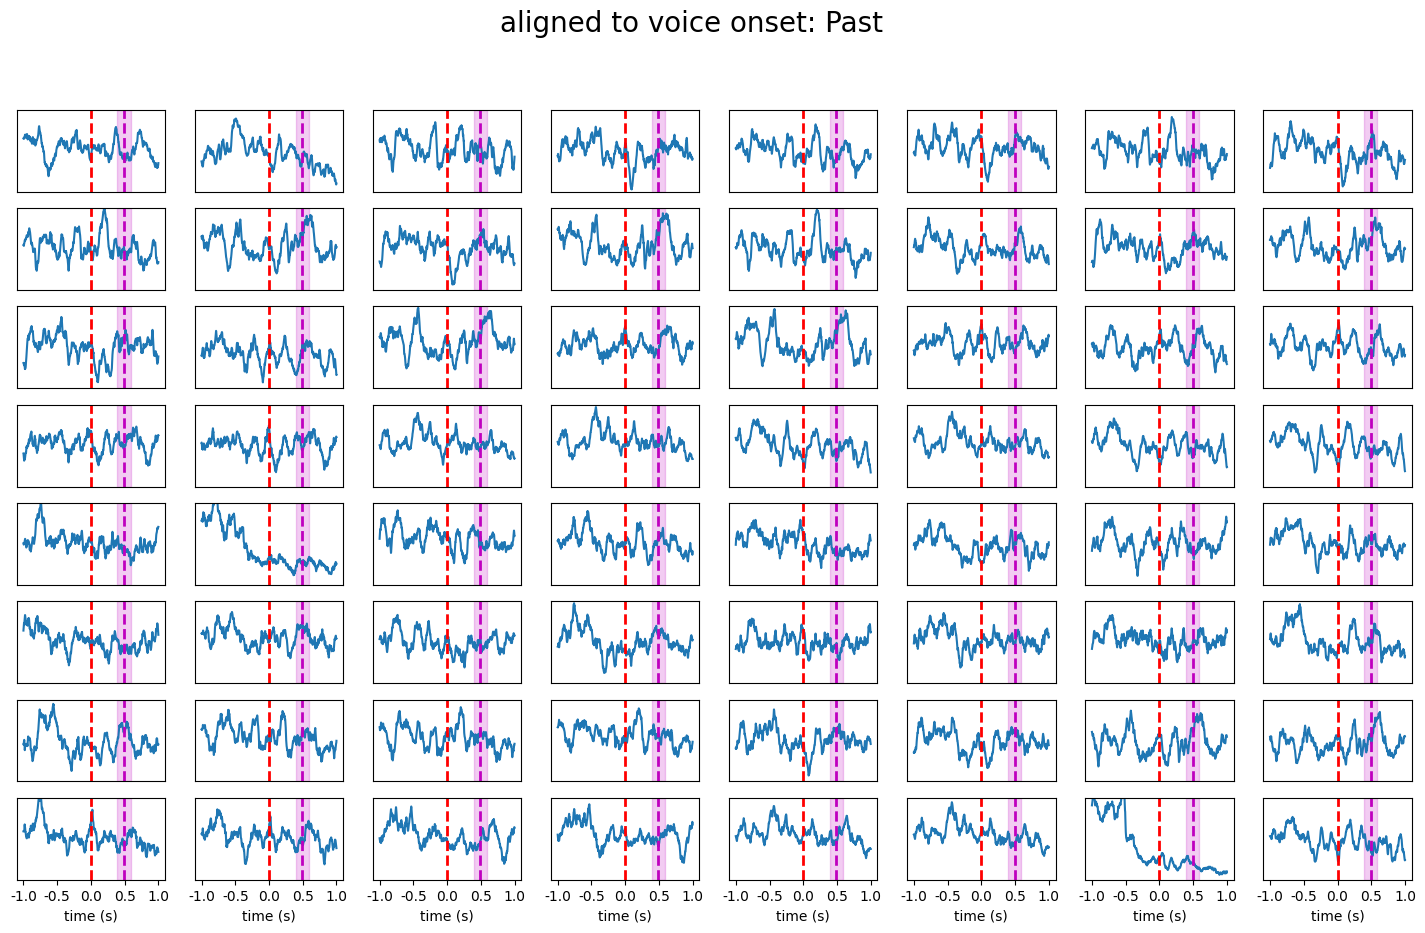

In [17]:
# plotting trial-averaged data in aligning to the phrase onset. 1s before and 8s after
processed_data_voice_on=[trial[:,int(voice_on[i]*fs-1*fs) : int(voice_on[i]*fs+1*fs)] for i,trial in enumerate(zscored_data)]
length=[trial.shape[1] for trial in processed_data_voice_on]
min_length=min(length)
processed_data_voice_on=np.stack([trial[:,:min_length] for trial in processed_data_voice_on]) # n_trials x n_channels x n_time_points
trial_averaged_data_voice_on=processed_data_voice_on[answered_label=='1',:,:].mean(axis=0) # getting rid of the baseline period

ave_voice_on=1

ave_phrase_on=-(voice_on-phrase_on).mean()+ave_voice_on
std_phrase_on=(voice_on-phrase_on).std()

ave_word_on=-(voice_on-word_on).mean()+ave_voice_on
std_word_on=(voice_on-word_on).std()

ave_voice_off=-(voice_on-voice_off).mean()+ave_voice_on
std_voice_off=(voice_off-voice_on).std()

fig,ax=plt.subplots(8,8,figsize=(18,10))
for i in range(trial_averaged_data.shape[0]):
    ax[i//8,i%8].plot(trial_averaged_data_voice_on[i])
    ax[i//8,i%8].set_ylim([trial_averaged_data_voice_on_min[i],trial_averaged_data_voice_on_max[i]])
    ax[i//8,i%8].set_yticks([])
    if i//8!=7:   
        ax[i//8,i%8].set_xticks([])
    else:
        ax[i//8,i%8].set_xticks(np.linspace(0,2*fs,5), [f"{i:0.1f}" for i in np.linspace(-1,1,5)])
        ax[i//8,i%8].set_xlabel("time (s)")
    
    #ax[i//8,i%8].axvspan(ave_phrase_on*fs-std_phrase_on*fs,ave_phrase_on*fs+std_phrase_on*fs,color='k',alpha=0.2)
    #ax[i//8,i%8].axvspan(ave_word_on * fs - std_word_on * fs, ave_word_on * fs + std_word_on * fs, color='g', alpha=0.2)
    #ax[i//8,i%8].axvspan(ave_voice_on * fs - std_voice_on * fs, ave_voice_on * fs + std_voice_on * fs, color='r', alpha=0.2)
    ax[i//8,i%8].axvspan(ave_voice_off * fs - std_voice_off * fs, ave_voice_off * fs + std_voice_off * fs, color='m', alpha=0.2)
    
    #ax[i//8,i%8].axvline(ave_phrase_on * fs, color='k', linestyle='--', linewidth=2)
    #ax[i//8,i%8].axvline(ave_word_on * fs, color='g', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_on * fs, color='r', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_off * fs, color='m', linestyle='--', linewidth=2)
plt.suptitle("aligned to voice onset: Past",fontsize=20)
plt.show()

# Here we are violently trying to decode the syntax aligning to voice onset

### feature selection
- bin the data to 50 ms
- use 1 bin per electrode as features. This results in 64 features per bin
- use a linear decoder to decoder past vs present

In [154]:
import collections
collections.Counter(answered_lexical_item)

Counter({'rub': 8,
         'chew': 7,
         'cry': 7,
         'run': 7,
         'tip': 6,
         'fail': 5,
         'jump': 5,
         'need': 5,
         'vote': 5,
         'snore': 5,
         'look': 5,
         'grab': 5,
         'wipe': 5,
         'kick': 4,
         'heal': 4,
         'lick': 4,
         'peek': 4,
         'kiss': 4,
         'punch': 3,
         'star': 3,
         'yell': 3,
         'see': 3,
         'cut': 3,
         'bite': 3,
         'mix': 3,
         'chase': 3,
         'stare': 3,
         'write': 2,
         'hop': 2,
         'load': 1,
         'walk': 1,
         'type': 1})

In [155]:
collections.Counter(answered_semantic_label)

Counter({'h': 36, 'm': 33, 'a': 21, 'l': 21, 'e': 18})

In [221]:
collections.Counter(first_phonemes)

Counter({'K': 18,
         'R': 17,
         'S': 14,
         'CH': 10,
         'L': 10,
         'P': 7,
         'T': 7,
         'HH': 6,
         'W': 6,
         'F': 5,
         'JH': 5,
         'N': 5,
         'V': 5,
         'G': 5,
         'Y': 3,
         'B': 3,
         'M': 3})

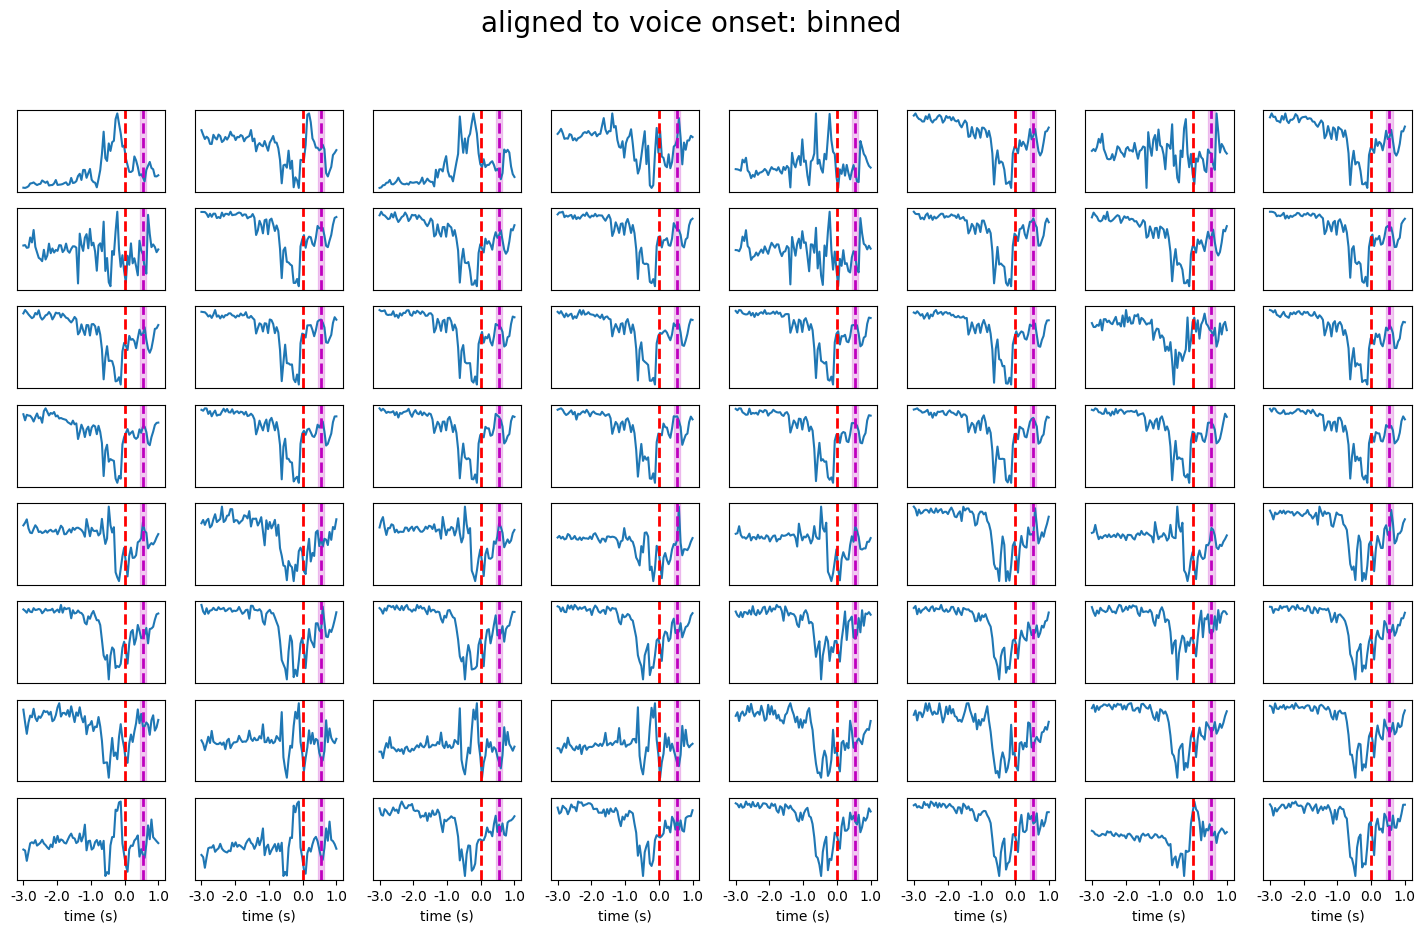

In [222]:
# define the decoding time range and bin the data
# aligning to the voice onset

back=3 # looking back 3 seconds before onset
forward=1 # looking forward 1 second after onset
bin_size=0.05 # s
adjusted_fs=1/bin_size # Hz
processed_data_voice_on=[trial[:,int(voice_on[i]*fs-back*fs) : int(voice_on[i]*fs+forward*fs)] for i,trial in enumerate(zscored_data)]
n_channels=processed_data_voice_on[0].shape[0]
n_trials_total=len(processed_data_voice_on)
binned_data_voice_on=[trial.reshape(n_channels,int(bin_size*fs),-1,order='F').mean(axis=1) for trial in processed_data_voice_on]
binned_data_voice_on_averaged=np.mean(binned_data_voice_on,axis=0)
n_bins=binned_data_voice_on_averaged.shape[-1]

ave_voice_on=back

ave_phrase_on=-(voice_on-phrase_on).mean()+ave_voice_on
std_phrase_on=(voice_on-phrase_on).std()

ave_word_on=-(voice_on-word_on).mean()+ave_voice_on
std_word_on=(voice_on-word_on).std()

ave_voice_off=-(voice_on-voice_off).mean()+ave_voice_on
std_voice_off=(voice_off-voice_on).std()

fig,ax=plt.subplots(8,8,figsize=(18,10))
for i in range(n_channels):
    ax[i//8,i%8].plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_voice_on_averaged[i])
    ax[i//8,i%8].set_yticks([])
    if i//8!=7:   
        ax[i//8,i%8].set_xticks([])
    else:
        ax[i//8,i%8].set_xticks(np.linspace(0,(back+forward)*adjusted_fs,5), [f"{i:0.1f}" for i in np.linspace(-back,forward,5)])
        ax[i//8,i%8].set_xlabel("time (s)")
    
    ax[i//8,i%8].axvspan(ave_voice_off * adjusted_fs - std_voice_off * adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off * adjusted_fs, color='m', alpha=0.2)
    
    ax[i//8,i%8].axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
plt.suptitle("aligned to voice onset: binned",fontsize=20)
plt.show()

In [236]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.decomposition import PCA

def reformat(data, bins_per_feature):
    reformatted_data=[]
    for i in range(data.shape[1]):
        reformatted=data[:,i-np.minimum(i, bins_per_feature):i,:]
        reformatted_data.append(reformatted.reshape(data.shape[0],-1))
    return reformatted_data
# build a decoder using PCs and multiple bins
# build decoder for each bin

#### syntax labels
# data_to_use=np.swapaxes(np.array(binned_data_voice_on)[answered_label!='1',:,:],1,2)
# labels_to_use=answered_label[answered_label!='1']

#### lexical labels
# data_to_use=np.swapaxes(np.array(binned_data_voice_on)[(answered_lexical_item=='run')|(answered_lexical_item=='chew'),:,:],1,2)
# labels_to_use=answered_lexical_item[(answered_lexical_item=='run')|(answered_lexical_item=='chew')]

#### semantic labels
# criteria=(answered_semantic_label=='a')|(answered_semantic_label=='e')
# data_to_use=np.swapaxes(np.array(binned_data_voice_on)[:,:,:],1,2)
# labels_to_use=answered_semantic_label[:]


#### first phoneme labels
criteria=(first_phonemes=='R')|(first_phonemes=='CH')
data_to_use=np.swapaxes(np.array(binned_data_voice_on)[criteria,:,:],1,2)
labels_to_use=first_phonemes[criteria]


# define how many bins we want in each feature
n_bins_per_feature=8
## perform PCA
n_PC=10
pca=PCA(n_components=n_PC)
pca.fit(data_to_use.reshape(-1,n_channels))
reduced_data=(pca.transform(data_to_use.reshape(-1,n_channels))/pca.singular_values_).reshape(-1,n_bins,n_PC)

# reformat the data
X=reformat(reduced_data,n_bins_per_feature) # data is a list

### start decoding
decoder=SVC()
#decoder=LinearSVC()
averaged_accuracy=[]
averaged_chance=[]
for j in range(200):
    accuracy=[]
    chance=[]
    for n_bin in range(len(X)):
        X_train, X_test, y_train, y_test =get_train_test(X[n_bin],labels_to_use,train=0.8)
        if X_train.shape[1] !=0:
            decoder.fit(X_train, y_train)
            y_predict=decoder.predict(X_test)
            correct=np.sum(y_predict==y_test)
            accuracy.append(correct/len(y_predict))
                     
            np.random.shuffle(X_train)      
            decoder.fit(X_train, y_train)
            y_predict=decoder.predict(X_test)
            correct=np.sum(y_predict==y_test)
            chance.append(correct/len(y_predict))
        else:
            accuracy.append(np.NaN)
            chance.append(np.NaN)
        
    averaged_accuracy.append(accuracy)
    averaged_chance.append(chance)


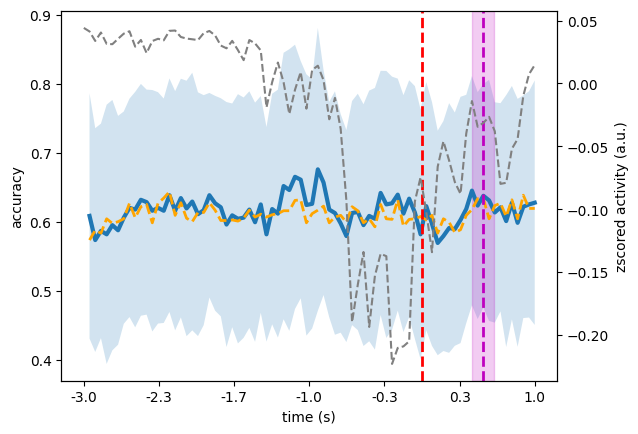

In [237]:
fig,ax=plt.subplots(1,1,)
ax.fill_between(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),
                np.mean(averaged_accuracy,axis=0)-np.std(averaged_accuracy,axis=0),
               np.mean(averaged_accuracy,axis=0)+np.std(averaged_accuracy,axis=0),alpha=0.2)
ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(averaged_accuracy,axis=0),lw=3)
ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(averaged_chance,axis=0),lw=2,linestyle='--',color='orange')
ax2=ax.twinx()
ax2.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_voice_on_averaged.mean(axis=0),c='grey',linestyle='--')
ax.axvspan(ave_voice_off * adjusted_fs - std_voice_off * adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off * adjusted_fs, color='m', alpha=0.2)
    
ax.axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
ax.axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
#ax.axhline(0.69798658,linestyle='--',color='orange') # between 1 and 2 ### chance level hand calculated by the number of labels because I am lazy.
#ax.axhline(0.57692308,linestyle='--',color='orange') # between 2 and 3 ### chance level hand calculated by the number of labels because I am lazy.
#ax.axhline(0.44,linestyle='--',color='orange') # between 2 and 3 ### chance level hand calculated by the number of labels because I am lazy.
ax.set_xticks(np.linspace(0,len(accuracy),7), [f"{i:0.1f}" for i in np.linspace(-back,forward,7)])
ax.set_xlabel("time (s)")
ax.set_ylabel("accuracy")
ax2.set_ylabel("zscored activity (a.u.)")
plt.show()

## decoding based on word onset

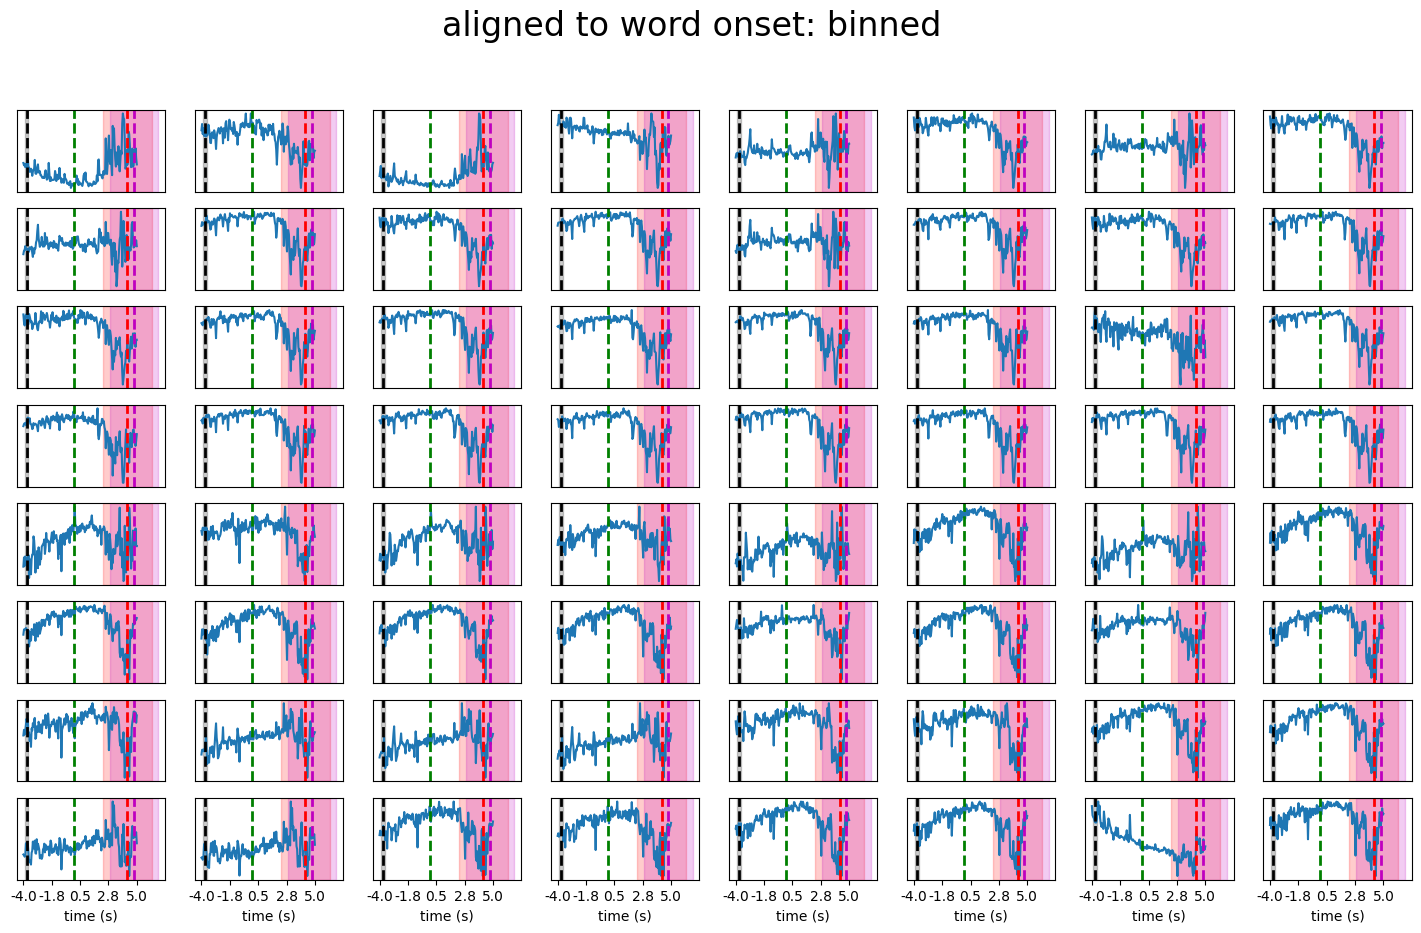

In [209]:
# define the decoding time range and bin the data
# aligning to the voice onset

back=4# looking back 3 seconds before onset
forward=5# looking forward 1 second after onset
bin_size=0.05 # s
adjusted_fs=1/bin_size # Hz
processed_data_word_on=[trial[:,int(word_on[i]*fs-back*fs) : int(word_on[i]*fs+forward*fs)] for i,trial in enumerate(zscored_data)]
n_channels=processed_data_word_on[0].shape[0]
n_trials_total=len(processed_data_word_on)
binned_data_word_on=[trial.reshape(n_channels,int(bin_size*fs),-1,order='F').mean(axis=1) for trial in processed_data_word_on]
binned_data_word_on_averaged=np.mean(binned_data_word_on,axis=0)
n_bins=binned_data_word_on_averaged.shape[-1]

ave_word_on=back

ave_phrase_on=-(word_on-phrase_on).mean()+ave_word_on
std_phrase_on=(word_on-phrase_on).std()

ave_voice_on=(voice_on-word_on).mean()+ave_word_on
std_voice_on=(voice_on-word_on).std()

ave_voice_off=-(word_on-voice_off).mean()+ave_word_on
std_voice_off=(voice_off-word_on).std()

fig,ax=plt.subplots(8,8,figsize=(18,10))
for i in range(n_channels):
    ax[i//8,i%8].plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_word_on_averaged[i])
    ax[i//8,i%8].set_yticks([])
    if i//8!=7:   
        ax[i//8,i%8].set_xticks([])
    else:
        ax[i//8,i%8].set_xticks(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),5), [f"{i:0.1f}" for i in np.linspace(-back,forward,5)])
        ax[i//8,i%8].set_xlabel("time (s)")
    
    ax[i//8,i%8].axvspan(ave_phrase_on*adjusted_fs-std_phrase_on* adjusted_fs,ave_phrase_on*adjusted_fs+std_phrase_on* adjusted_fs,color='k',alpha=0.2)
    #ax[i//8,i%8].axvspan(ave_word_on * adjusted_fs - std_word_on * fs, ave_word_on * fs + std_word_on * fs, color='g', alpha=0.2)
    ax[i//8,i%8].axvspan(ave_voice_on * adjusted_fs - std_voice_on* adjusted_fs, ave_voice_on*adjusted_fs + std_voice_on* adjusted_fs, color='r', alpha=0.2)
    ax[i//8,i%8].axvspan(ave_voice_off * adjusted_fs - std_voice_off* adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off* adjusted_fs, color='m', alpha=0.2)
    
    ax[i//8,i%8].axvline(ave_phrase_on * adjusted_fs, color='k', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_word_on * adjusted_fs, color='g', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
    ax[i//8,i%8].axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
plt.suptitle("aligned to word onset: binned",fontsize=24)
plt.show()

In [211]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC,SVC
from sklearn.decomposition import PCA

def reformat(data, bins_per_feature):
    reformatted_data=[]
    for i in range(data.shape[1]):
        reformatted=data[:,i-np.minimum(i, bins_per_feature):i,:]
        reformatted_data.append(reformatted.reshape(data.shape[0],-1))
    return reformatted_data
# build a decoder using PCs and multiple bins
# build decoder for each bin

# data_to_use=np.swapaxes(np.array(binned_data_word_on)[answered_label!='1',:,:],1,2)
# labels_to_use=answered_label[answered_label!='1']

criteria=(answered_semantic_label=='h')|(answered_semantic_label=='m')
data_to_use=np.swapaxes(np.array(binned_data_word_on)[criteria,:,:],1,2)
labels_to_use=answered_semantic_label[criteria]

# define how many bins we want in each feature
n_bins_per_feature=8
## perform PCA
n_PC=10
pca=PCA(n_components=n_PC)
pca.fit(data_to_use.reshape(-1,n_channels))
reduced_data=(pca.transform(data_to_use.reshape(-1,n_channels))/pca.singular_values_).reshape(-1,n_bins,n_PC)

# reformat the data
X=reformat(reduced_data,n_bins_per_feature) # data is a list

### start decoding
decoder=SVC()
#decoder=LinearSVC()
averaged_accuracy=[]
averaged_chance=[]
for j in range(200):
    accuracy=[]
    chance=[]
    for n_bin in range(len(X)):
        X_train, X_test, y_train, y_test =get_train_test(X[n_bin],labels_to_use,train=0.8)
        if X_train.shape[1] !=0:
            decoder.fit(X_train, y_train)
            y_predict=decoder.predict(X_test)
            correct=np.sum(y_predict==y_test)
            accuracy.append(correct/len(y_predict))
                     
            np.random.shuffle(X_train)      
            decoder.fit(X_train, y_train)
            y_predict=decoder.predict(X_test)
            correct=np.sum(y_predict==y_test)
            chance.append(correct/len(y_predict))
        else:
            accuracy.append(np.NaN)
            chance.append(np.NaN)
        
    averaged_accuracy.append(accuracy)
    averaged_chance.append(chance)

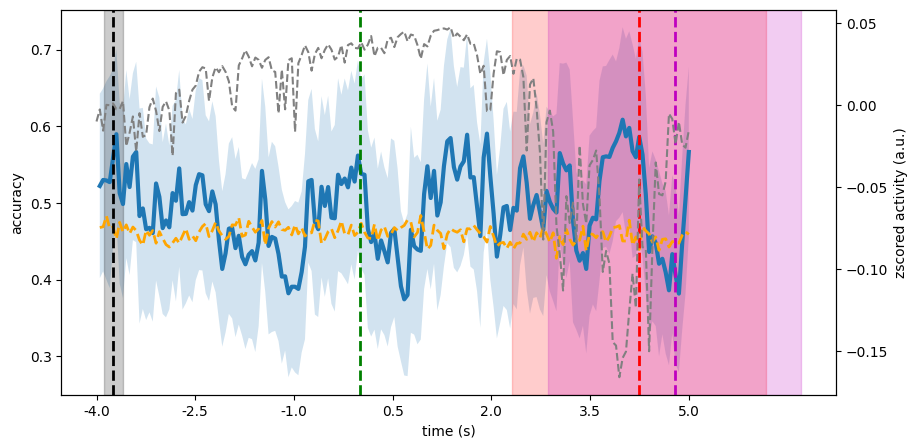

In [212]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
ax.fill_between(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),
                np.mean(averaged_accuracy,axis=0)-np.std(averaged_accuracy,axis=0),
               np.mean(averaged_accuracy,axis=0)+np.std(averaged_accuracy,axis=0),alpha=0.2)
ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(averaged_accuracy,axis=0),lw=3)
ax.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),np.mean(averaged_chance,axis=0),lw=2,linestyle='--',color='orange')
ax2=ax.twinx()
ax2.plot(np.linspace(0,(back*adjusted_fs+forward*adjusted_fs),n_bins),binned_data_word_on_averaged.mean(axis=0),c='grey',linestyle='--')
ax.axvspan(ave_phrase_on*adjusted_fs-std_phrase_on* adjusted_fs,ave_phrase_on*adjusted_fs+std_phrase_on* adjusted_fs,color='k',alpha=0.2)
#ax[i//8,i%8].axvspan(ave_word_on * adjusted_fs - std_word_on * fs, ave_word_on * fs + std_word_on * fs, color='g', alpha=0.2)
ax.axvspan(ave_voice_on * adjusted_fs - std_voice_on* adjusted_fs, ave_voice_on*adjusted_fs + std_voice_on* adjusted_fs, color='r', alpha=0.2)
ax.axvspan(ave_voice_off * adjusted_fs - std_voice_off* adjusted_fs, ave_voice_off * adjusted_fs + std_voice_off* adjusted_fs, color='m', alpha=0.2)

ax.axvline(ave_phrase_on * adjusted_fs, color='k', linestyle='--', linewidth=2)
ax.axvline(ave_word_on * adjusted_fs, color='g', linestyle='--', linewidth=2)
ax.axvline(ave_voice_on * adjusted_fs, color='r', linestyle='--', linewidth=2)
ax.axvline(ave_voice_off * adjusted_fs, color='m', linestyle='--', linewidth=2)
#ax.axhline(0.69798658,linestyle='--',color='orange') # between 1 and 2 ### chance level hand calculated by the number of labels because I am lazy.
#ax.axhline(0.57692308,linestyle='--',color='orange') # between 2 and 3 ### chance level hand calculated by the number of labels because I am lazy.
#ax.axhline(0.5,linestyle='--',color='orange') # between 2 and 3 ### chance level hand calculated by the number of labels because I am lazy.
ax.set_xticks(np.linspace(0,len(accuracy),7), [f"{i:0.1f}" for i in np.linspace(-back,forward,7)])
ax.set_xlabel("time (s)")
ax.set_ylabel("accuracy")
ax2.set_ylabel("zscored activity (a.u.)")
plt.show()